<a href="https://colab.research.google.com/github/chaiminwoo0223/Deep-Learning/blob/main/23%20-%20Caltech101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 최고의 성능을 위한 Tool
- ResNet
- Dropout
- Hyperparameter Tuning

## 1. Settings
### 1) Import required libraries

In [1]:
!pip install pretrainedmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import matplotlib.pyplot as plt
import matplotlib
import argparse 
import joblib
import cv2
import os
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import pickle
import random
import torchvision

import pretrainedmodels

matplotlib.style.use('ggplot')

from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models, datasets
from tqdm import tqdm

def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

SEED=42
seed_everything(SEED=SEED)

### 2) Set hyperparameters

In [3]:
batch_size = 32
learning_rate = 1e-5
num_epoch = 20

## 2. Data

### 1) Download Data

In [4]:
data = datasets.Caltech101("./", download=True)

Files already downloaded and verified


### 2) Check Dataset

In [5]:
image_paths = list(paths.list_images('./caltech101/101_ObjectCategories'))

data = []
labels = []
for img_path in tqdm(image_paths):
    label = img_path.split(os.path.sep)[-2]
    if label == "BACKGROUND_Google":
        continue
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    data.append(img)
    labels.append(label)
    
data = np.array(data)
labels = np.array(labels)

100%|██████████| 9144/9144 [00:17<00:00, 528.89it/s]
<ipython-input-5-4a2715adf468>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


In [6]:
label_names = labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(len(lb.classes_))
print(labels)
print(label_names)

101
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
['barrel' 'barrel' 'barrel' ... 'crocodile' 'crocodile' 'crocodile']


In [7]:
count_arr = []
label_arr = []
for i in range(len(lb.classes_)):
    count = 0
    for j in range(len(label_names)):
        if lb.classes_[i] in label_names[j]:
            count += 1
    count_arr.append(count)
    label_arr.append(lb.classes_[i])

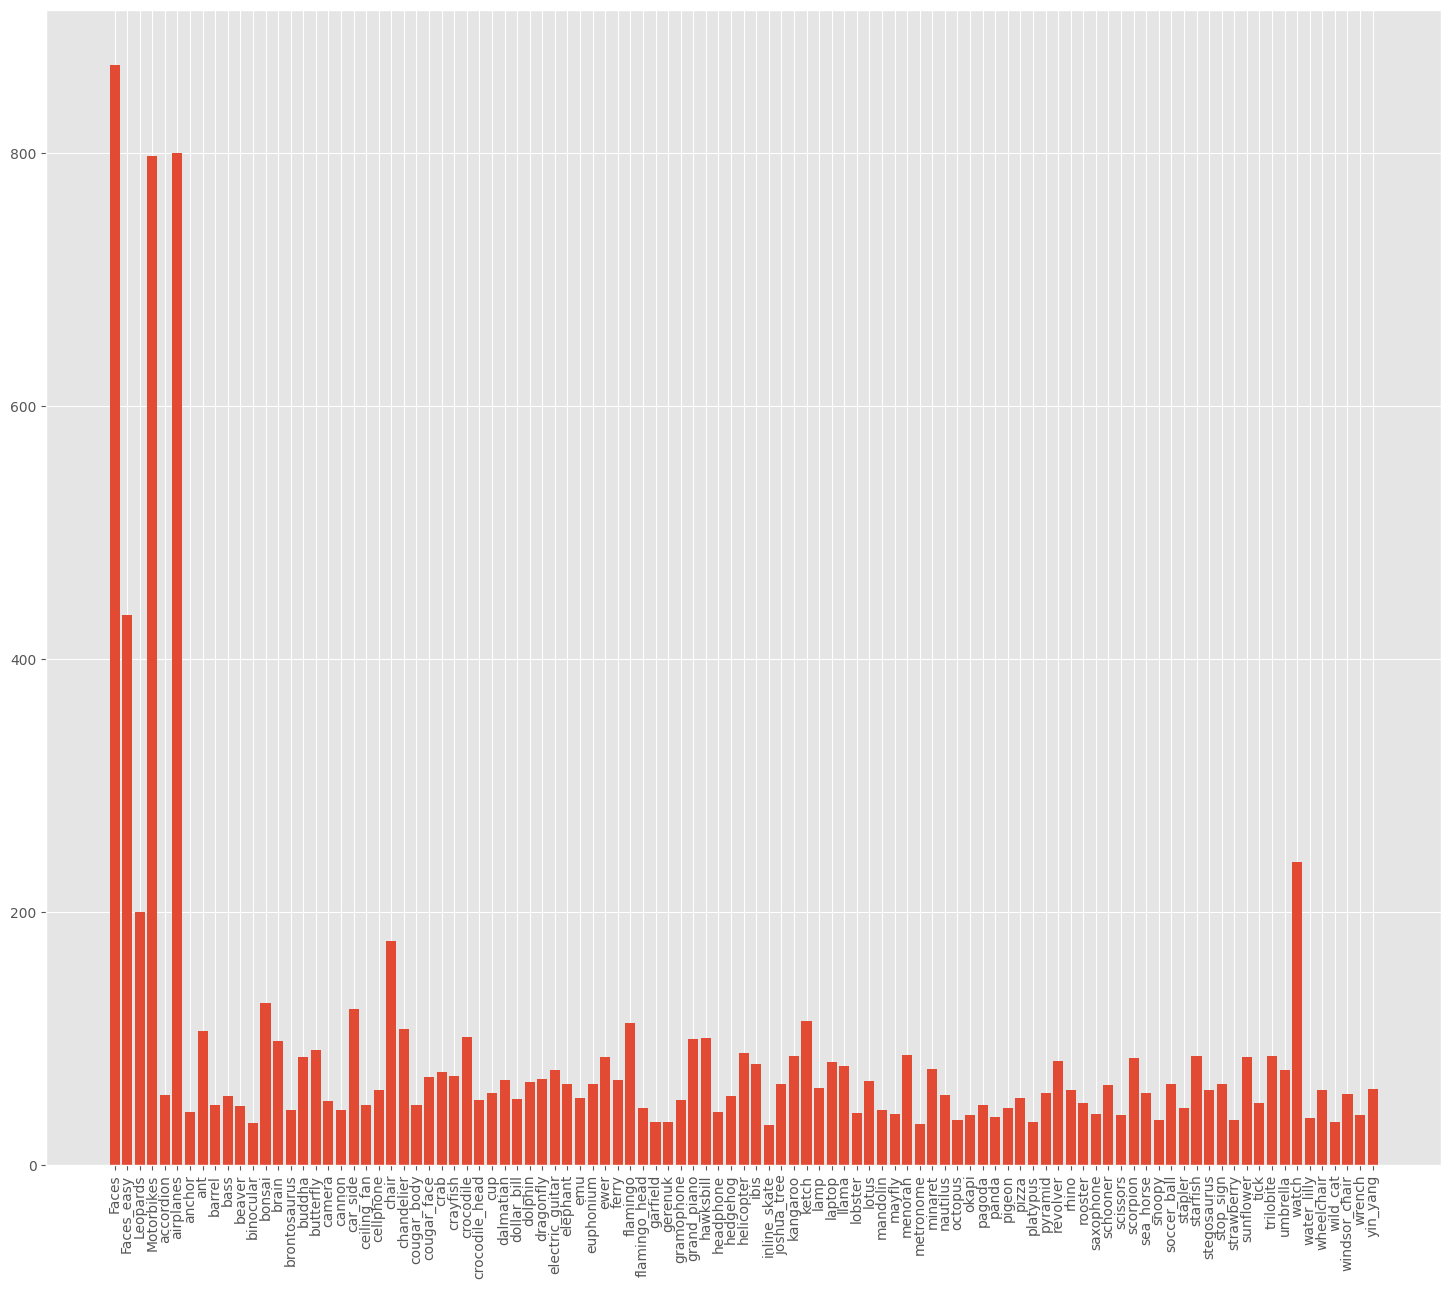

In [8]:
plt.figure(figsize=(18, 15))
plt.bar(label_arr, count_arr,)
plt.xticks(rotation='vertical')
plt.show()

### 3) Set DataLoader

In [9]:
# divide the data into train, validation, and test set
(x_train, x_test, y_train, y_test) = train_test_split(data, labels, test_size=0.2,  stratify=labels,random_state=42)
(x_train, x_val, y_train, y_val) = train_test_split(x_train, y_train, test_size=0.25, random_state=42)
print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")

x_train examples: (5205,)
x_test examples: (1736,)
x_val examples: (1736,)


In [10]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transforms=None):
        self.x = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.x))
    
    def __getitem__(self, i):
        data = self.x[i][:]
        
        if self.transforms is not None:
            data = self.transforms(data)
            
        return (data, self.y[i])

In [11]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])    

In [12]:
train_data = CustomDataset(x_train, y_train, train_transform)
val_data = CustomDataset(x_val, y_val, val_transform)
test_data = CustomDataset(x_test, y_test, val_transform)
 
# dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=2)

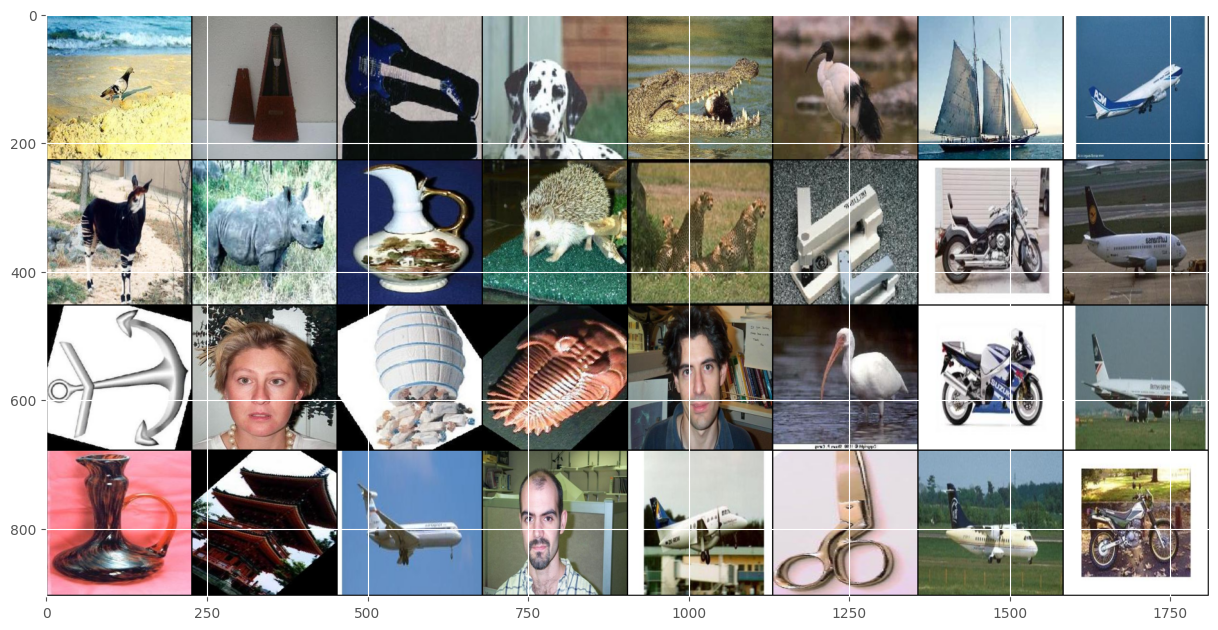

In [13]:
def imshow(img):
    plt.figure(figsize=(15, 12))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images))

## 3. Model & Optimizer

### 1) CNN Model

In [14]:
class ResNet34(nn.Module):
    def __init__(self, pretrained):
        super(ResNet34, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__['resnet34'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['resnet34'](pretrained=None)
        
        # change the classification layer
        self.l0 = nn.Linear(512, len(lb.classes_))
        self.dropout = nn.Dropout2d(0.4)
    def forward(self, x):
        # get the batch size only, ignore (c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        x = self.dropout(x)
        l0 = self.l0(x)
        return l0

### 2) Loss func & Optimizer

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [16]:
model = ResNet34(pretrained=True).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## 4. Train 

In [17]:
def train(model, dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = loss_func(outputs, torch.max(target, 1)[1])
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/len(dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    
    return train_loss, train_accuracy

In [18]:
def validate(model, dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = loss_func(outputs, torch.max(target, 1)[1])
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        
        val_loss = val_running_loss/len(dataloader.dataset)
        val_accuracy = 100. * val_running_correct/len(dataloader.dataset)
        
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        
        return val_loss, val_accuracy

In [19]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(num_epoch):
    print(f"Epoch {epoch+1} of {num_epoch}")
    train_epoch_loss, train_epoch_accuracy = train(model, train_loader)
    val_epoch_loss, val_epoch_accuracy = validate(model, val_loader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()

print((end-start)/60, 'minutes')

Epoch 1 of 20


  0%|          | 0/162 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
100%|██████████| 162/162 [00:27<00:00,  5.80it/s]

Train Loss: 0.1210, Train Acc: 21.19



100%|██████████| 54/54 [00:05<00:00, 10.46it/s]

Val Loss: 0.0908, Val Acc: 41.13
Epoch 2 of 20



100%|██████████| 162/162 [00:26<00:00,  6.20it/s]

Train Loss: 0.0851, Train Acc: 43.48



100%|██████████| 54/54 [00:03<00:00, 13.75it/s]

Val Loss: 0.0701, Val Acc: 61.64
Epoch 3 of 20



100%|██████████| 162/162 [00:26<00:00,  6.20it/s]

Train Loss: 0.0646, Train Acc: 61.46



100%|██████████| 54/54 [00:04<00:00, 13.25it/s]

Val Loss: 0.0525, Val Acc: 72.81
Epoch 4 of 20



100%|██████████| 162/162 [00:26<00:00,  6.21it/s]

Train Loss: 0.0481, Train Acc: 74.76



100%|██████████| 54/54 [00:04<00:00, 10.81it/s]

Val Loss: 0.0397, Val Acc: 80.53
Epoch 5 of 20



100%|██████████| 162/162 [00:26<00:00,  6.22it/s]

Train Loss: 0.0362, Train Acc: 83.09



100%|██████████| 54/54 [00:04<00:00, 13.27it/s]

Val Loss: 0.0311, Val Acc: 85.37
Epoch 6 of 20



100%|██████████| 162/162 [00:26<00:00,  6.21it/s]

Train Loss: 0.0275, Train Acc: 88.78



100%|██████████| 54/54 [00:04<00:00, 11.45it/s]

Val Loss: 0.0249, Val Acc: 88.13
Epoch 7 of 20



100%|██████████| 162/162 [00:26<00:00,  6.18it/s]

Train Loss: 0.0210, Train Acc: 91.89



100%|██████████| 54/54 [00:03<00:00, 13.60it/s]

Val Loss: 0.0198, Val Acc: 90.44
Epoch 8 of 20



100%|██████████| 162/162 [00:26<00:00,  6.22it/s]

Train Loss: 0.0161, Train Acc: 94.62



100%|██████████| 54/54 [00:03<00:00, 13.81it/s]

Val Loss: 0.0164, Val Acc: 91.82
Epoch 9 of 20



100%|██████████| 162/162 [00:26<00:00,  6.23it/s]

Train Loss: 0.0124, Train Acc: 96.62



100%|██████████| 54/54 [00:05<00:00, 10.64it/s]

Val Loss: 0.0141, Val Acc: 93.03
Epoch 10 of 20



100%|██████████| 162/162 [00:26<00:00,  6.22it/s]

Train Loss: 0.0095, Train Acc: 97.68



100%|██████████| 54/54 [00:03<00:00, 13.53it/s]

Val Loss: 0.0124, Val Acc: 93.55
Epoch 11 of 20



100%|██████████| 162/162 [00:26<00:00,  6.22it/s]

Train Loss: 0.0076, Train Acc: 98.46



100%|██████████| 54/54 [00:03<00:00, 13.68it/s]

Val Loss: 0.0106, Val Acc: 93.95
Epoch 12 of 20



100%|██████████| 162/162 [00:26<00:00,  6.17it/s]

Train Loss: 0.0058, Train Acc: 98.96



100%|██████████| 54/54 [00:04<00:00, 11.88it/s]

Val Loss: 0.0102, Val Acc: 94.12
Epoch 13 of 20



100%|██████████| 162/162 [00:26<00:00,  6.22it/s]

Train Loss: 0.0047, Train Acc: 99.04



100%|██████████| 54/54 [00:03<00:00, 13.60it/s]

Val Loss: 0.0090, Val Acc: 94.18
Epoch 14 of 20



100%|██████████| 162/162 [00:26<00:00,  6.20it/s]


Train Loss: 0.0039, Train Acc: 99.35


100%|██████████| 54/54 [00:05<00:00,  9.46it/s]

Val Loss: 0.0086, Val Acc: 94.70
Epoch 15 of 20



100%|██████████| 162/162 [00:25<00:00,  6.23it/s]

Train Loss: 0.0032, Train Acc: 99.40



100%|██████████| 54/54 [00:03<00:00, 13.54it/s]

Val Loss: 0.0082, Val Acc: 94.70
Epoch 16 of 20



100%|██████████| 162/162 [00:26<00:00,  6.20it/s]

Train Loss: 0.0026, Train Acc: 99.46



100%|██████████| 54/54 [00:04<00:00, 13.32it/s]

Val Loss: 0.0079, Val Acc: 94.93
Epoch 17 of 20



100%|██████████| 162/162 [00:26<00:00,  6.20it/s]


Train Loss: 0.0022, Train Acc: 99.50


100%|██████████| 54/54 [00:04<00:00, 12.31it/s]

Val Loss: 0.0073, Val Acc: 95.16
Epoch 18 of 20



100%|██████████| 162/162 [00:26<00:00,  6.23it/s]

Train Loss: 0.0019, Train Acc: 99.50



100%|██████████| 54/54 [00:03<00:00, 13.76it/s]

Val Loss: 0.0069, Val Acc: 95.51
Epoch 19 of 20



100%|██████████| 162/162 [00:26<00:00,  6.21it/s]

Train Loss: 0.0016, Train Acc: 99.54



100%|██████████| 54/54 [00:05<00:00, 10.71it/s]

Val Loss: 0.0069, Val Acc: 95.22
Epoch 20 of 20



100%|██████████| 162/162 [00:26<00:00,  6.22it/s]

Train Loss: 0.0014, Train Acc: 99.54



100%|██████████| 54/54 [00:03<00:00, 13.60it/s]

Val Loss: 0.0068, Val Acc: 95.16
10.288082154591878 minutes


In [20]:
torch.save(model.state_dict(), f"model_{num_epoch}.pth")

[21.191162343900096, 43.47742555235351, 61.460134486071084, 74.75504322766571, 83.09317963496638, 88.78001921229587, 91.89241114313161, 94.6205571565802, 96.61863592699328, 97.67531219980788, 98.4630163304515, 98.96253602305475, 99.03938520653217, 99.34678194044189, 99.40441882804996, 99.46205571565802, 99.50048030739673, 99.50048030739673, 99.53890489913545, 99.53890489913545]
[0.12098733501635871, 0.08505795915807014, 0.06460968880099133, 0.04811121265437028, 0.0361767278166486, 0.027474576910451326, 0.021004194353316175, 0.0160670693051231, 0.01236054099430612, 0.009485559126829208, 0.00755477376589972, 0.00582570567311975, 0.004724273098477025, 0.003913125323487748, 0.003197911265060148, 0.0026387227897771153, 0.002189975635190633, 0.001931337617144461, 0.0016411727407050752, 0.0014418779774841841]
[41.12903225806452, 61.63594470046083, 72.8110599078341, 80.52995391705069, 85.36866359447005, 88.13364055299539, 90.43778801843318, 91.82027649769586, 93.02995391705069, 93.548387096774

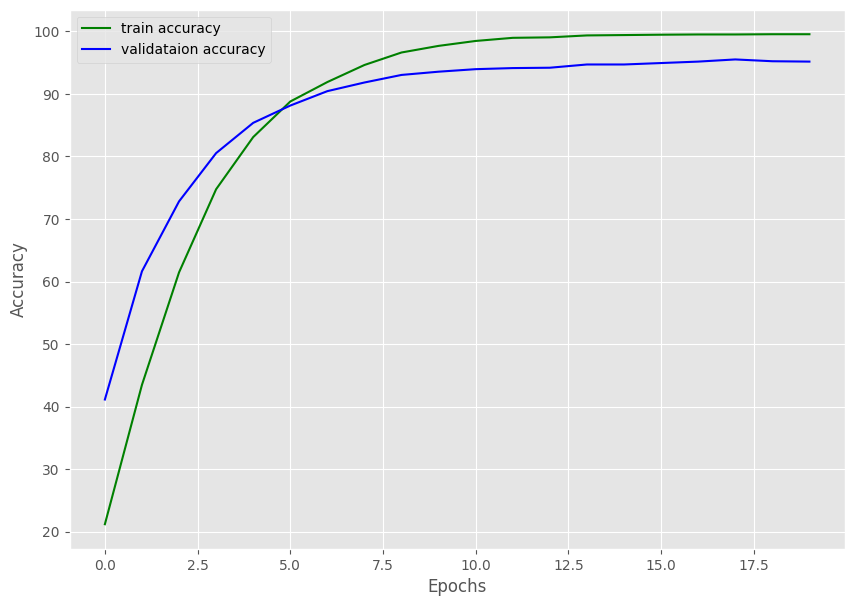

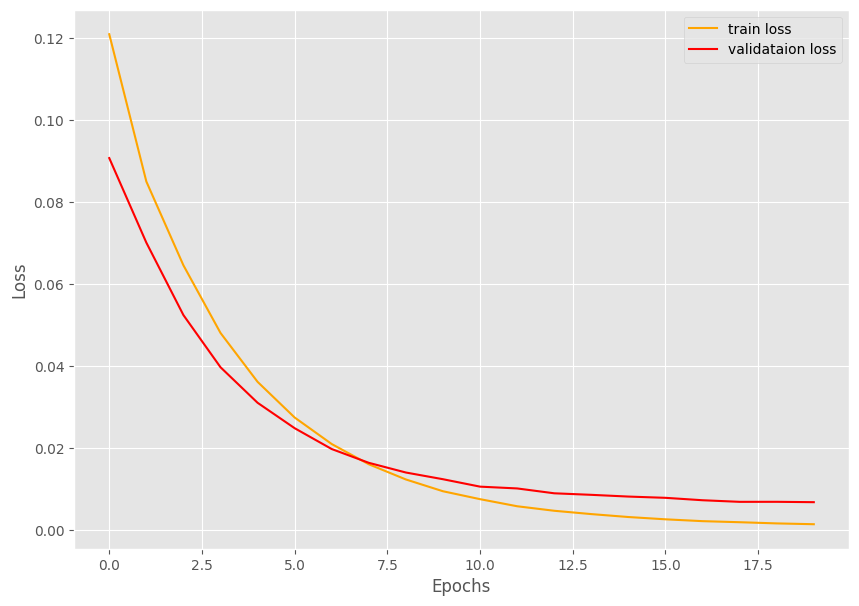

['val_loss.pkl']

In [21]:
print(train_accuracy)
print(train_loss)
print(val_accuracy)
print(val_loss)

# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

import joblib
joblib.dump(train_accuracy, 'train_accuracy.pkl')
joblib.dump(train_loss, 'train_loss.pkl')
joblib.dump(val_accuracy, 'val_accuracy.pkl')
joblib.dump(val_loss, 'val_loss.pkl')

In [22]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs = data[0].to(device, non_blocking=True)
        target = data[1].to(device, non_blocking=True)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == torch.max(target, 1)[1]).sum().item()

print('Accuracy of the network on test images: %0.3f %%' % (100 * correct / total))

Accuracy of the network on test images: 95.891 %
